# Import Data

In [1]:
import pandas as pd
train_df = pd.read_csv('../../input/feedback-prize-english-language-learning/train.csv')


model_path_list = [
    '../../01_Baseline/exp/result/01_v1_27/oof_df.csv', # deberta-v3-base
    '../../01_Baseline/exp/result/01_v1_43/oof_df.csv', # deberta-v3-large
    '../../01_Baseline/exp/result/01_v1_24/oof_df.csv', # deberta-base
    '../../01_Baseline/exp/result/01_v1_25/oof_df.csv', # deberta-large
    '../../01_Baseline/exp/result/01_v1_45/oof_df.csv', # roberta-large
]

oof_df_list = [
    pd.read_csv(model_path) for model_path in model_path_list
]

for oof_df in oof_df_list:
    oof_df = train_df[['text_id']].merge(oof_df, how='left', on='text_id')
    
num_models = len(model_path_list)

TARGET_COLS = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']

stack_df = oof_df_list[0][['text_id']]
for i in range(num_models):
    oof_df = oof_df_list[i]
    for col in TARGET_COLS:
        stack_df[f'{col}_{i}'] = oof_df[col].values
        
        
train_df = train_df[['text_id']+TARGET_COLS].merge(stack_df, on='text_id', how='left')

/home/takesako/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [2]:
train_df.head()

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cohesion_0,syntax_0,vocabulary_0,...,vocabulary_3,phraseology_3,grammar_3,conventions_3,cohesion_4,syntax_4,vocabulary_4,phraseology_4,grammar_4,conventions_4
0,0016926B079C,3.5,3.5,3.0,3.0,4.0,3.0,2.885453,2.860759,3.071929,...,3.120876,3.150779,3.208785,2.907158,2.923405,2.831063,2.912158,3.103420,3.065863,2.769381
1,0022683E9EA5,2.5,2.5,3.0,2.0,2.0,2.5,2.521122,2.440580,2.711392,...,2.850700,2.709038,2.587375,2.587828,2.536946,2.380513,2.800518,2.592651,2.413749,2.427189
2,00299B378633,3.0,3.5,3.0,3.0,3.0,2.5,2.843849,2.967711,2.917809,...,3.094973,2.980881,3.055136,2.833445,2.829473,2.762232,2.867777,2.815092,2.863168,2.902894
3,003885A45F42,4.5,4.5,4.5,4.5,4.0,5.0,3.642689,3.595627,3.678757,...,3.846789,3.849410,3.860160,4.146064,3.548078,3.525499,3.610355,3.724175,3.698088,3.715907
4,0049B1DF5CCC,2.5,3.0,3.0,3.0,2.5,2.5,2.658665,2.453293,2.795006,...,2.709118,2.647390,2.518007,2.496209,2.536176,2.404460,2.743569,2.690457,2.631302,2.564926


# Features

In [12]:
feature_cols = [col for col in stack_df.columns if col!='text_id']

# Data Split

In [3]:
from os.path import join as opj

class args:
    fold_path = '../../00_EDA/00_v1_02/result/'
    num_fold = 5
    
fold_path = args.fold_path
import joblib
print('load folds...')
trn_ids_list = joblib.load(opj(fold_path,f'trn_ids_list.joblib'))
val_ids_list = joblib.load(opj(fold_path,f'val_ids_list.joblib'))

load folds...


# Stacking

In [13]:
import matplotlib.pyplot as plt

def show_feature_importance(model):
    feature_importance = model.get_feature_importance()
    fi_df = pd.DataFrame({'importance':feature_importance, 'features':feature_cols})
    fi_df = fi_df.sort_values('importance', ascending=True)

    plt.figure(figsize=(12, 6))
    plt.barh(range(len(fi_df)),
            fi_df['importance'].values,
            tick_label=fi_df['features'].values)
    plt.xlabel('importance')
    plt.ylabel('features')
    plt.grid()
    plt.show()

In [14]:
import catboost
params = {
    'random_state':45, 
    'n_estimators':20000,
    'loss_function':'MultiRMSE',
}

import numpy as np
def calc_metric(pred, gt):
    '''
    pred : (num_data, num_labels)
    gt : (num_data, num_labels)
    '''
    score = np.sqrt(np.mean((pred - gt)**2, axis=0))
    score = score.mean()
    return score

fold0 : CV=0.4538


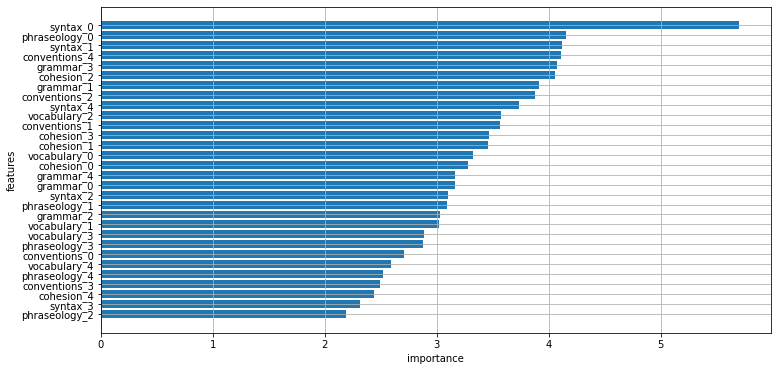

fold1 : CV=0.4472


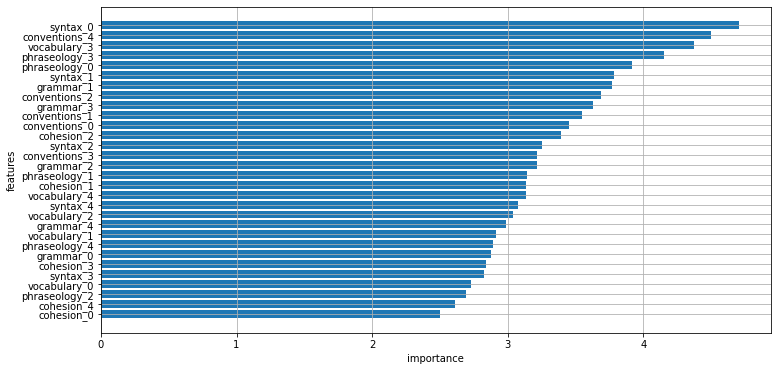

fold2 : CV=0.4485


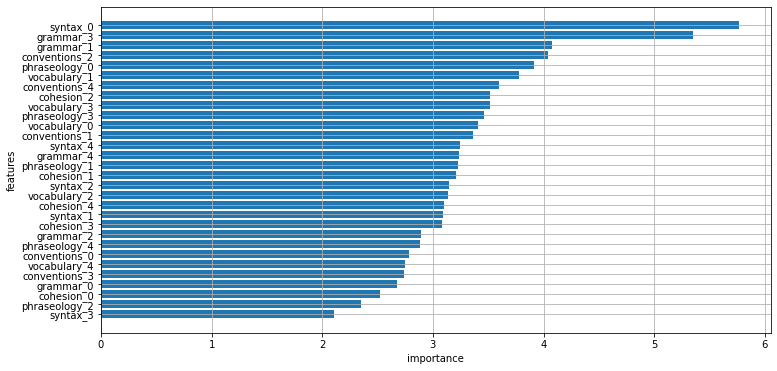

fold3 : CV=0.4571


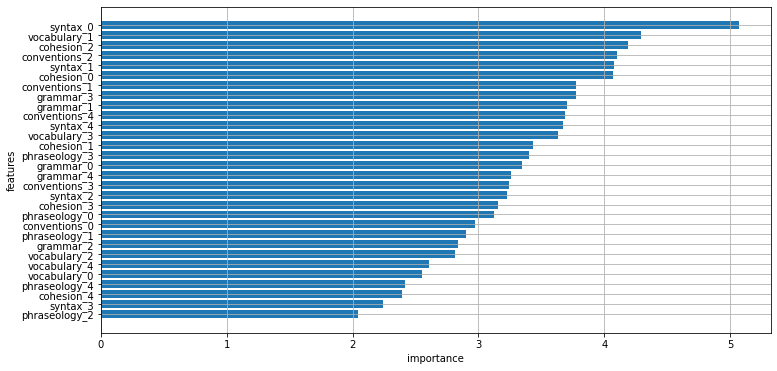

fold4 : CV=0.4582


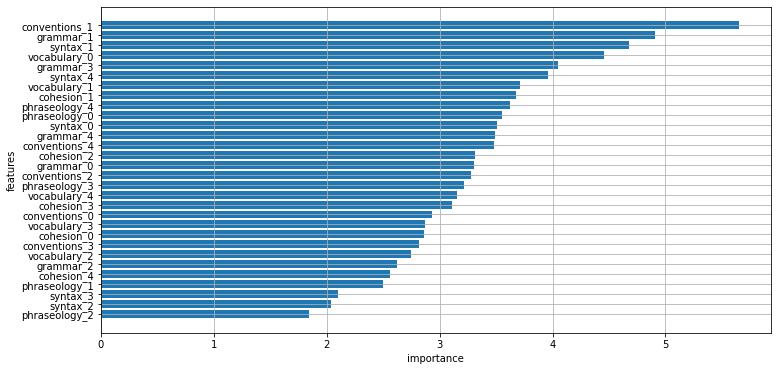

CV=0.4530


In [17]:
from sklearn.metrics import log_loss
import pickle
import os
os.makedirs('./result', exist_ok=True)

cat_features = []


score_list = []
oof_df = []
for fold in range(args.num_fold):
    trn_df = train_df[train_df['text_id'].isin(trn_ids_list[fold])].reset_index(drop=True)
    val_df = train_df[train_df['text_id'].isin(val_ids_list[fold])].reset_index(drop=True)

    pool_trn = catboost.Pool(trn_df[feature_cols].values, label=trn_df[TARGET_COLS].values, cat_features=cat_features)
    pool_val = catboost.Pool(val_df[feature_cols].values, label=val_df[TARGET_COLS].values, cat_features=cat_features)

    model = catboost.CatBoostRegressor(**params)
    model.fit(pool_trn, 
              eval_set=[pool_val], 
              verbose=0, 
              early_stopping_rounds=100,
             )

    pred = model.predict(pool_val)
    target = val_df[TARGET_COLS].values
    score = calc_metric(pred, target)
    print('fold{} : CV={:.4f}'.format(fold, score))
    score_list.append(score)
    for i,col in enumerate(TARGET_COLS):
        val_df[f'oof_{col}'] = pred[:,i]
    oof_df.append(val_df)
    # save model
    joblib.dump(model, f'./result/cat_fold{fold}.joblib')
    # plot
    show_feature_importance(model)
    
CV = sum(score_list) / len(score_list)
print('CV={:.4f}'.format(CV))

In [18]:
oof_df = pd.concat(oof_df).reset_index(drop=True)
oof_df = train_df[['text_id']].merge(oof_df, on='text_id', how='left')
oof_df.to_csv(f'./result/oof_cat.csv', index=False)
print(oof_df.shape)
oof_df.head()

(3911, 43)


,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cohesion_0,syntax_0,vocabulary_0,...,vocabulary_4,phraseology_4,grammar_4,conventions_4,oof_cohesion,oof_syntax,oof_vocabulary,oof_phraseology,oof_grammar,oof_conventions
0,0016926B079C,3.5,3.5,3.0,3.0,4.0,3.0,2.885453,2.860759,3.071929,...,2.912158,3.103420,3.065863,2.769381,2.916810,2.917914,3.091518,3.071504,3.122617,2.920713
1,0022683E9EA5,2.5,2.5,3.0,2.0,2.0,2.5,2.521122,2.440580,2.711392,...,2.800518,2.592651,2.413749,2.427189,2.613237,2.540407,2.796648,2.592952,2.505777,2.454040
2,00299B378633,3.0,3.5,3.0,3.0,3.0,2.5,2.843849,2.967711,2.917809,...,2.867777,2.815092,2.863168,2.902894,2.920223,2.865934,3.072795,2.973115,2.953722,2.996204
3,003885A45F42,4.5,4.5,4.5,4.5,4.0,5.0,3.642689,3.595627,3.678757,...,3.610355,3.724175,3.698088,3.715907,3.590077,3.576990,3.681014,3.592786,3.566026,3.650677
4,0049B1DF5CCC,2.5,3.0,3.0,3.0,2.5,2.5,2.658665,2.453293,2.795006,...,2.743569,2.690457,2.631302,2.564926,2.524766,2.379355,2.755326,2.558194,2.391288,2.316215


In [19]:
cols = [col for col in oof_df.columns if col.startswith('oof_')]

oof_score = calc_metric(oof_df[cols].values, oof_df[TARGET_COLS].values)
print('oof={:.4f}'.format(oof_score))

oof=0.4530
